# Welcome the practice notebook 
--- 
The objective of this practice is to provide a hands-on experience in data exploration and cleaning. Please follow the instructions provided in the  notebook to complete the practice.

Installing pyspark

In [18]:
!pip install pyspark
!pip install setuptools
!pip install distutils
!pip install matplotlib
!pip install plotly
!pip install seaborn
!pip install pandas
!pip install scipy

ERROR: Could not find a version that satisfies the requirement distutils (from versions: none)
ERROR: No matching distribution found for distutils
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 14.4 MB/s eta 0:00:00a 0:00:01


Importing the needed modules and creating the spark session

In [31]:
# importing spark session
from pyspark.sql import SparkSession

# data visualization modules 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff 

# pandas module 
import pandas as pd
import numpy as np

# pyspark SQL functions 
from pyspark.sql.functions import col, when, count, sum

# creating the spark session
spark = SparkSession.builder.appName("Customer_Churn_Prediction").getOrCreate()
spark

Loading the `parctice-dataset.csv` file

In [20]:
data = spark.read.format('csv').option('header',True).option('inferSchema',True).load('Practice_dataset.csv')
data.show(5)


+----------+------------+------------+------------+------------+----------------+
|EmployeeID|        KPI1|        KPI2|        KPI3|        KPI4|Current Employee|
+----------+------------+------------+------------+------------+----------------+
|         0|-1.039682384|-0.716426478|-0.513467693| 0.414661471|               0|
|         1| 0.237093465|-0.820123996|-0.865801274| 0.438661047|               0|
|         2|-2.077948003| 0.185688029|-0.132418305| 0.711280402|               1|
|         3|-0.684711628| 1.522335039| 1.674082146|-1.234292085|               1|
|         4|-1.137117653|-0.555136531|-0.176780706|-1.776008972|               0|
+----------+------------+------------+------------+------------+----------------+
only showing top 5 rows



How many rows and columns do we have in the dataset? 

In [21]:
print(f'Dataset has {data.count()} rows and {len(data.columns)} columns')

Dataset has 10000 rows and 6 columns


Create a histogram matrix to analyse the distributions of the numerical columns. 

- *Hint 1: List of the numerical columns = `["KPI1","KPI2","KPI3","KPI4"]`* <br>
- *Hint 2: To create the histograms, first you will need to convert the pyspark dataframe into a pandas dataframe.*

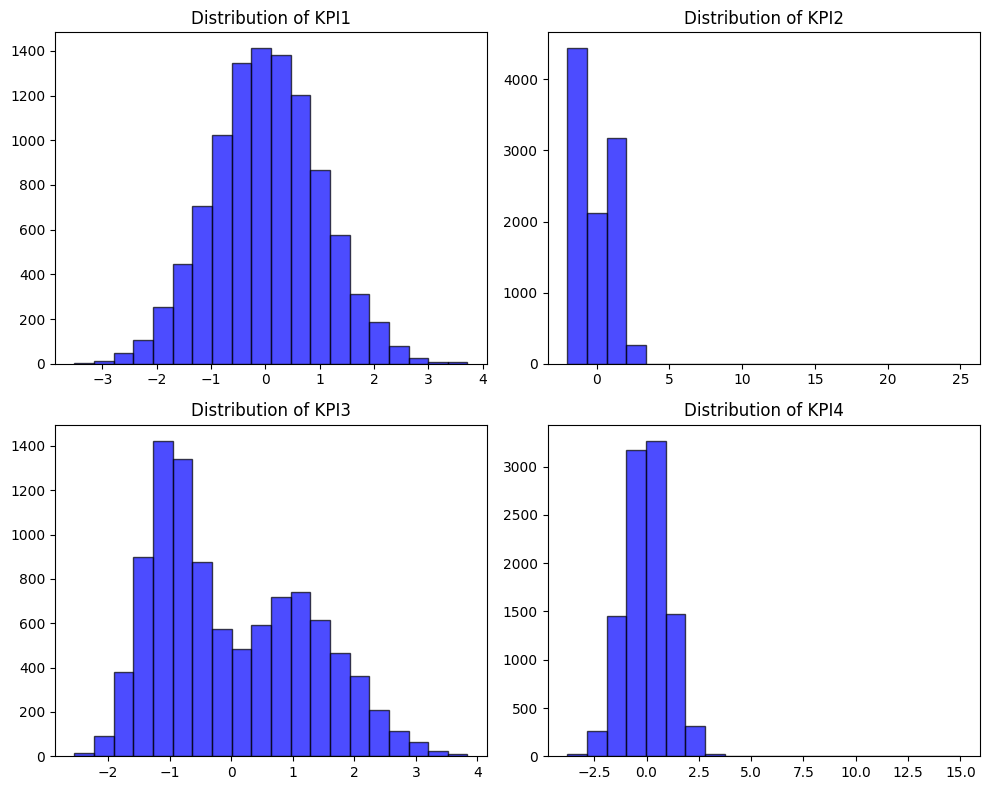

In [22]:
# Convert PySpark DataFrame to Pandas
numerical_col = ["KPI1","KPI2","KPI3","KPI4"]
pdf = data.select(numerical_col).toPandas()

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(10,8))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot histogram for each column
for i, col in enumerate(numerical_col):
    axes[i].hist(pdf[col], bins=20, alpha=0.7, color="blue", edgecolor="black")
    axes[i].set_title(f"Distribution of {col}")
    
plt.tight_layout()
plt.show()


Observe the distributions of the numerical columns in the histograms generated in the previous part.
- Find the columns with outilers
- Remove the outliers

In [28]:
# Functions to detect outliers using IQR

def detect_outlier_iqr(df, columns):
    outlier_dict = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Find the outliers
        outliers = df[(df[col] < lower_bound) | (df[col]> upper_bound)][col]
        outlier_dict[col] = outliers
        
    return outlier_dict

# Identify the outliers
outliers = detect_outlier_iqr(pdf, numerical_col)
print("Outliers detected in each column:\n", {k: len(v) for k, v in outliers.items()})        

Outliers detected in each column:
 {'KPI1': 72, 'KPI2': 1, 'KPI3': 0, 'KPI4': 62}


In [29]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Keep only values within the acceptable range
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        
    return df

# Remove outliers
pdf_cleaned = remove_outliers(pdf, numerical_col)

# Check the new dataset
print(f"Original dataset size: {pdf.shape[0]}, Cleaned dataset size: {pdf_cleaned.shape[0]}")

Original dataset size: 10000, Cleaned dataset size: 9857


Find the missing values in the dataset. 

In [35]:
# Count missing values for each column
missing_values = data.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in data.columns]
)

# Show missing values per column
missing_values.show()

+----------+----+----+----+----+----------------+
|EmployeeID|KPI1|KPI2|KPI3|KPI4|Current Employee|
+----------+----+----+----+----+----------------+
|         0|   4|   0|   2|   3|               0|
+----------+----+----+----+----+----------------+



Use **Mean Imputer** to fill the missing values

In [36]:
from pyspark.ml.feature import Imputer

# Initialize Imputer with 'mean' strategy
imputer = Imputer(inputCols=numerical_col, outputCols=[f"{c}_imputed" for c in numerical_col]).setStrategy("mean")

# Fit and transform data
data_imputed = imputer.fit(data).transform(data)

# Show results
data_imputed.select(numerical_col + [f"{c}_imputed" for c in numerical_col]).show()

+------------+------------+------------+------------+------------+------------+------------+------------+
|        KPI1|        KPI2|        KPI3|        KPI4|KPI1_imputed|KPI2_imputed|KPI3_imputed|KPI4_imputed|
+------------+------------+------------+------------+------------+------------+------------+------------+
|-1.039682384|-0.716426478|-0.513467693| 0.414661471|-1.039682384|-0.716426478|-0.513467693| 0.414661471|
| 0.237093465|-0.820123996|-0.865801274| 0.438661047| 0.237093465|-0.820123996|-0.865801274| 0.438661047|
|-2.077948003| 0.185688029|-0.132418305| 0.711280402|-2.077948003| 0.185688029|-0.132418305| 0.711280402|
|-0.684711628| 1.522335039| 1.674082146|-1.234292085|-0.684711628| 1.522335039| 1.674082146|-1.234292085|
|-1.137117653|-0.555136531|-0.176780706|-1.776008972|-1.137117653|-0.555136531|-0.176780706|-1.776008972|
|-1.052934587| 0.119522573|-0.188215465|-0.867239924|-1.052934587| 0.119522573|-0.188215465|-0.867239924|
| 0.953745557| 0.738929252|   0.6416214|-1.069

Again, find the missing values in the dataset to make sure no missing value exists.

In [40]:
# Count missing values for each column
missing_values = data_imputed.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in data_imputed.columns]
)

# Show missing values per column
missing_values.show()

# Compute the total number of missing values across all columns
total_missing = missing_values.agg(
    sum(col(c) for c in data_imputed.columns).alias("total_missing")
).collect()[0]["total_missing"]

# Check if any missing values remain
if total_missing == 0:
    print("✅ No missing values remain in the dataset!")
else:
    print(f"⚠️ There are still {total_missing} missing values in the dataset.")

+----------+----+----+----+----+----------------+------------+------------+------------+------------+
|EmployeeID|KPI1|KPI2|KPI3|KPI4|Current Employee|KPI1_imputed|KPI2_imputed|KPI3_imputed|KPI4_imputed|
+----------+----+----+----+----+----------------+------------+------------+------------+------------+
|         0|   4|   0|   2|   3|               0|           0|           0|           0|           0|
+----------+----+----+----+----+----------------+------------+------------+------------+------------+



PySparkTypeError: [NOT_COLUMN_OR_STR] Argument `col` should be a Column or str, got generator.